# Урок 4. Алгоритм построения дерева решений

## Подготовим предварительные вычисления из методички

In [1]:
# подключим необходимые библиотеки

import matplotlib.pyplot as plt
import random
import numpy as np

from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn import model_selection

%matplotlib inline

In [2]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 2, 
                                                                          n_samples = 1000,
                                                                          n_informative = 2,
                                                                          n_classes = 2,
                                                                          n_redundant=0,
                                                                          n_clusters_per_class=1,
                                                                          random_state=1)

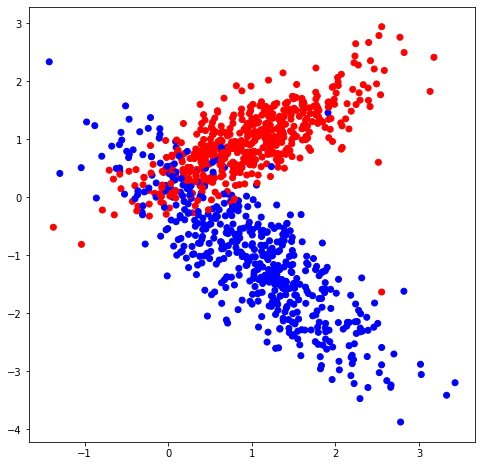

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction

In [6]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [7]:
# Расчет качества

#def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    #p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    #return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [8]:
# Данные фугкции используются для решения второго задания
def gini_cls(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

def entropy_cls(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        ent = p * np.log2(p) if p else 0
        impurity -= ent
        
    return impurity

def selected_crt_def(labels, flag=1):
    
    if flag:
        impurity = gini_cls(labels)
    else:
        impurity = entropy_cls(labels)
    
    return impurity

In [9]:
def quality(left_labels, right_labels, current_crt, criteria = 1):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_crt - p * selected_crt_def(left_labels, criteria) - (1 - p) * selected_crt_def(right_labels, criteria)

In [10]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [11]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, criteria = 1):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5
    
    current_crt = selected_crt_def(labels, criteria)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_crt, criteria)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [12]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, criteria = 1):

    quality, t, index = find_best_split(data, labels, criteria)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, criteria)
    false_branch = build_tree(false_data, false_labels, criteria)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [13]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [14]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [15]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


# Функция построения графика
def draw_graph(xx, yy):
    # график обучающей выборки
    plt.figure(figsize = (16, 7))
    plt.subplot(1,2,1)
    mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

In [16]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [17]:
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

### 1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.).

Реализуем ограничение на глубину дерева. Для этого добавим два пареметра:
*   n_layers - максимальная глубина;
*   layer - текущий уровень.

И будем передавать эти уровни в рекурсию. Начиная с первого.


In [18]:
# Перепишем функцию построение дерева с помощью рекурсивной функции
def build_tree(data, labels, layer=1, n_layers=10, criteria = 1):

    quality, t, index = find_best_split(data, labels, criteria)
    
    # Увеличим уровень дерева
    layer+=1

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    # Случай, когда прекращаем рекурсию, если уровень дерева стал выше заданного
    if layer > n_layers:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, layer, n_layers, criteria)
    false_branch = build_tree(false_data, false_labels, layer, n_layers, criteria)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

## Построим дерево с макисмальной глубиной 10 и критерием Джинни

Точность тренировочной выборки: 96.0
Точность тестовой выборки: 88.66666666666667


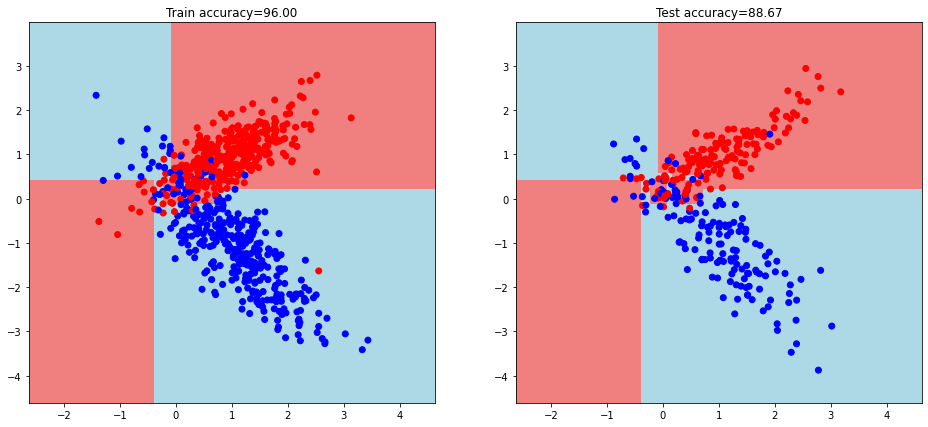

In [19]:
# Разобьем выборку на обучающую и тестовую
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 5)

# Построим дерево по обучающей выборке с уровнем дерева до 10
my_tree = build_tree(train_data, train_labels, 1, 10, 1)

# Напечатаем ход нашего дерева    
# print_tree(my_tree)

# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f"Точность тренировочной выборки: {train_accuracy}")

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
print(f"Точность тестовой выборки: {test_accuracy}")

# Визуализируем дерево на графике
xx, yy = get_meshgrid(train_data)
draw_graph(xx, yy)

## Построим дерево с максимальной глубиной 4 и критерием Джинни

Точность тренировочной выборки: 93.71428571428572
Точность тестовой выборки: 89.66666666666666


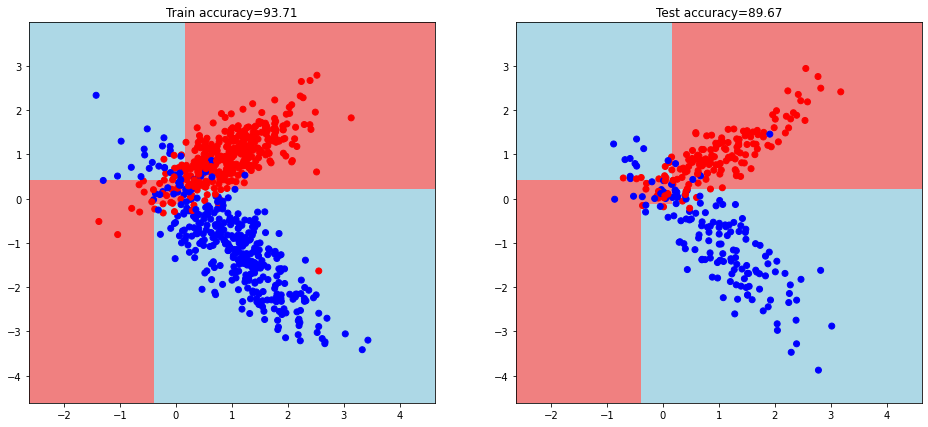

In [20]:
# Построим дерево по обучающей выборке с уровнем дерева до 4
my_tree = build_tree(train_data, train_labels, 1, 4, 1)

# Напечатаем ход нашего дерева    
# print_tree(my_tree)

# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f"Точность тренировочной выборки: {train_accuracy}")

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
print(f"Точность тестовой выборки: {test_accuracy}")

# Визуализируем дерево на графике
xx, yy = get_meshgrid(train_data)
draw_graph(xx, yy)

Видим, что в случае, если дерево ограничить 10 уровнями, то наблюдается небольшое переобучение. На train 96% а на test 88,67

В случае, если ограничим дерево 4 уровнями, то переобучение немного уменьшается и модель становится точнее. На train 93,71% а на test 89,67

### 2. Для задачи классификации обучить дерево решений с использованием критериев разбиения Джини и Энтропия. Сравнить качество классификации, сделать выводы.

Еще раз укажем функции, которые меняли, чтобы было более наглядно в ходе описания задачи.

In [21]:
def gini_cls(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity += p * (1-p)
        
    return impurity

def entropy_cls(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        ent = p * np.log2(p) if p else 0
        impurity -= ent
        
    return impurity

def selected_crt_def(labels, flag=1):
    
    if flag:
        impurity = gini_cls(labels)
    else:
        impurity = entropy_cls(labels)
    
    return impurity

## Построим дерево, используя критерий Джинни

Точность тренировочной выборки: 96.0
Точность тестовой выборки: 88.66666666666667


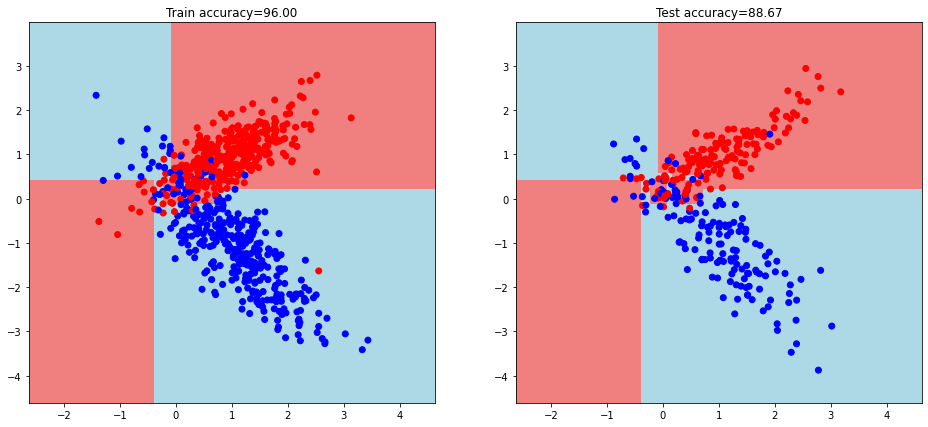

In [22]:
# Построим дерево по обучающей выборке с уровнем дерева до 10
my_tree = build_tree(train_data, train_labels, 1, 10, 1)

# Напечатаем ход нашего дерева    
# print_tree(my_tree)

# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f"Точность тренировочной выборки: {train_accuracy}")

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
print(f"Точность тестовой выборки: {test_accuracy}")

# Визуализируем дерево на графике
xx, yy = get_meshgrid(train_data)
draw_graph(xx, yy)

## Построим дерево, используя критерий энтропия Шеннона

Точность тренировочной выборки: 95.71428571428572
Точность тестовой выборки: 90.33333333333333


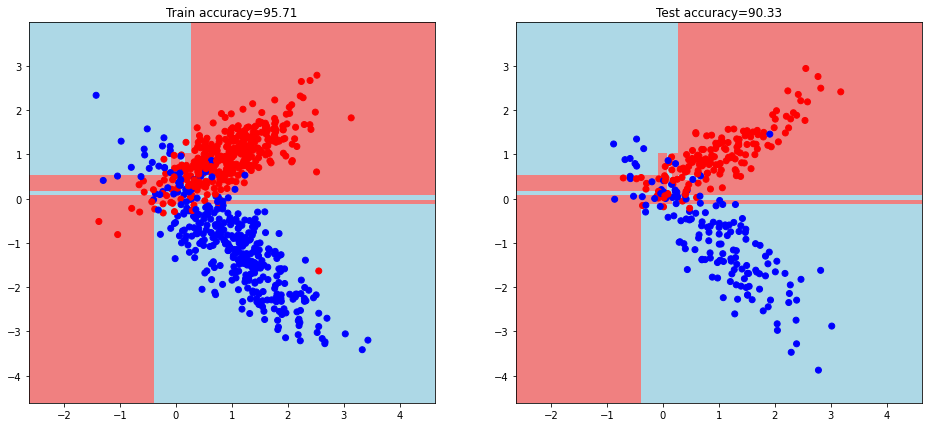

In [23]:
# Построим дерево по обучающей выборке с уровнем дерева до 10
my_tree = build_tree(train_data, train_labels, 1, 10, 0)

# Напечатаем ход нашего дерева    
# print_tree(my_tree)

# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f"Точность тренировочной выборки: {train_accuracy}")

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
print(f"Точность тестовой выборки: {test_accuracy}")

# Визуализируем дерево на графике
xx, yy = get_meshgrid(train_data)
draw_graph(xx, yy)

### Исходя из оценки точности видно, что критерий Шеннона дает немного более устойчивый результат, по отношении к критерию Джинни.

### Так же было замечено, что при использовании критерия Шеннона с ростом глубины дерева, результат на тесте становится лучше. В то время как при использовании критерия Джинии, с увеличением глубины дерева результат становится хуже. Неже представлены примеры для сравнения при глубине дерева 4.

Точность тренировочной выборки: 93.71428571428572
Точность тестовой выборки: 89.66666666666666


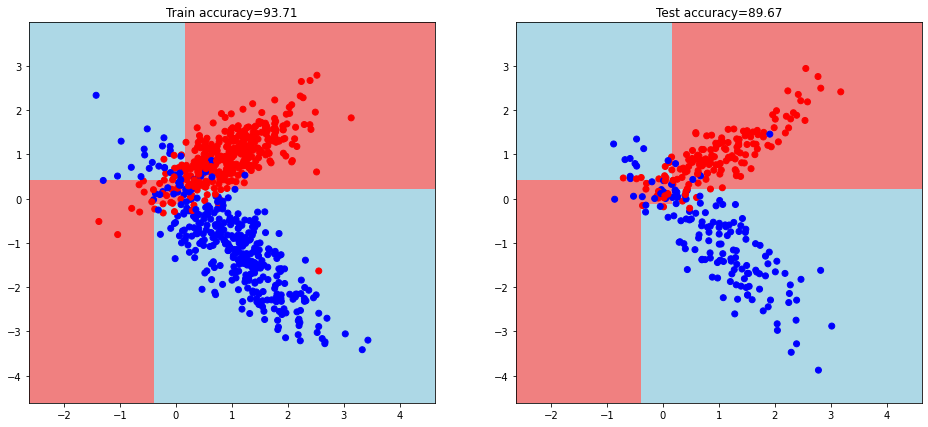

In [24]:
# Построим дерево по обучающей выборке с уровнем дерева до 10
my_tree = build_tree(train_data, train_labels, 1, 4, 1)

# Напечатаем ход нашего дерева    
# print_tree(my_tree)

# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f"Точность тренировочной выборки: {train_accuracy}")

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
print(f"Точность тестовой выборки: {test_accuracy}")

# Визуализируем дерево на графике
xx, yy = get_meshgrid(train_data)
draw_graph(xx, yy)

Точность тренировочной выборки: 92.0
Точность тестовой выборки: 86.33333333333333


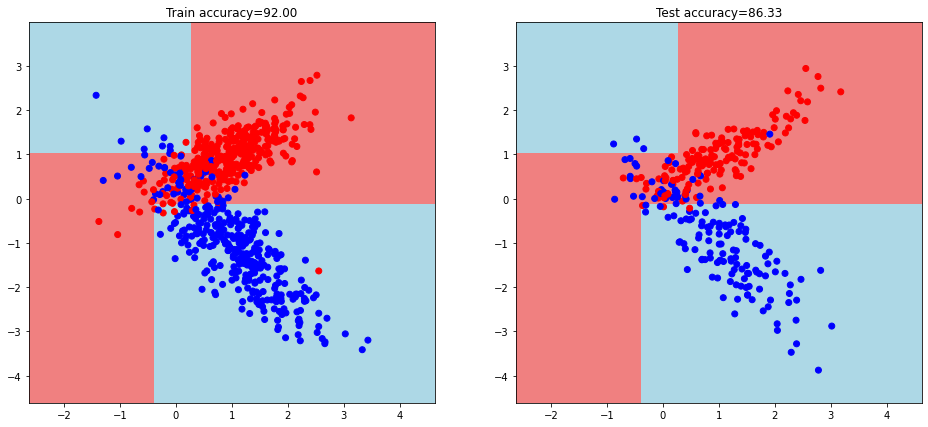

In [25]:
# Построим дерево по обучающей выборке с уровнем дерева до 10
my_tree = build_tree(train_data, train_labels, 1, 4, 0)

# Напечатаем ход нашего дерева    
# print_tree(my_tree)

# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f"Точность тренировочной выборки: {train_accuracy}")

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
print(f"Точность тестовой выборки: {test_accuracy}")

# Визуализируем дерево на графике
xx, yy = get_meshgrid(train_data)
draw_graph(xx, yy)